# Assignment 6

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

``Objectives``

* This assignment connects all the pieces involved in training feed-forward fully connected neural networks (FFNN);

* You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for two datasets, and then document your findings.

``Data``
* Digits MNIST
* Fashion MNIST

### Import libraries

In [20]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from keras.datasets import fashion_mnist
from keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
import keras
from keras import metrics
from keras import backend as K
tf.get_logger().setLevel('INFO')

---
### Step 1: Data ingestion

In [2]:
# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()

# Load the Digits MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


---
### Step 2: Data preprocessing

``Fashion MNIST``

In [3]:
# Normalize
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

``Digits MNIST``

In [4]:
# Normalize
X_train_digits = X_train_digits / 255.
X_test_digits = X_test_digits / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following task:

1. Show the first training example in X_train_fashion;
2. Show the first training example in X_train_digits;
3. Display the first 5 images in X_train_digits for each class in Y_train_digits, arranged in a 10x5 grid.

1. Shape of the first training example in X_train_fashion: (28, 28)
Showing the first training example in X_train_fashion:


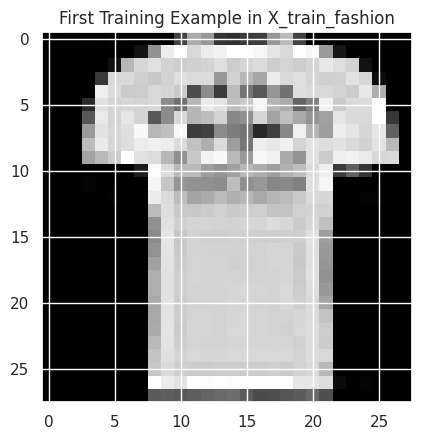

In [5]:
# YOUR CODE HERE

# 1. Showing the first training example in X_train_fashion
print("1. Shape of the first training example in X_train_fashion:",
  X_train_fashion[0].shape)
print("Showing the first training example in X_train_fashion:")
plt.imshow(X_train_fashion[0], cmap='gray')
plt.title("First Training Example in X_train_fashion")
plt.show()

2. Shape of the first training example in X_train_digits: (28, 28)
Showing the first training example in X_train_digits:


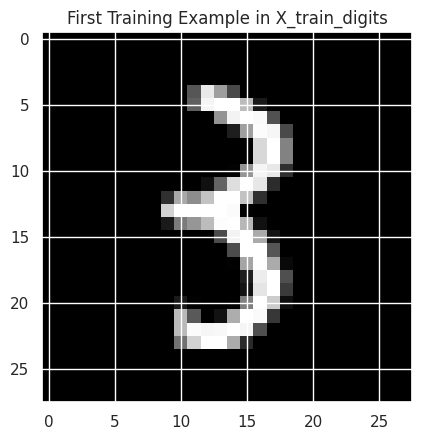

In [6]:
# 2. Showing the first training example in X_train_digits
print("2. Shape of the first training example in X_train_digits:",
  X_train_digits[0].shape)
print("Showing the first training example in X_train_digits:")
plt.imshow(X_train_digits[0], cmap='gray')
plt.title("First Training Example in X_train_digits")
plt.show()

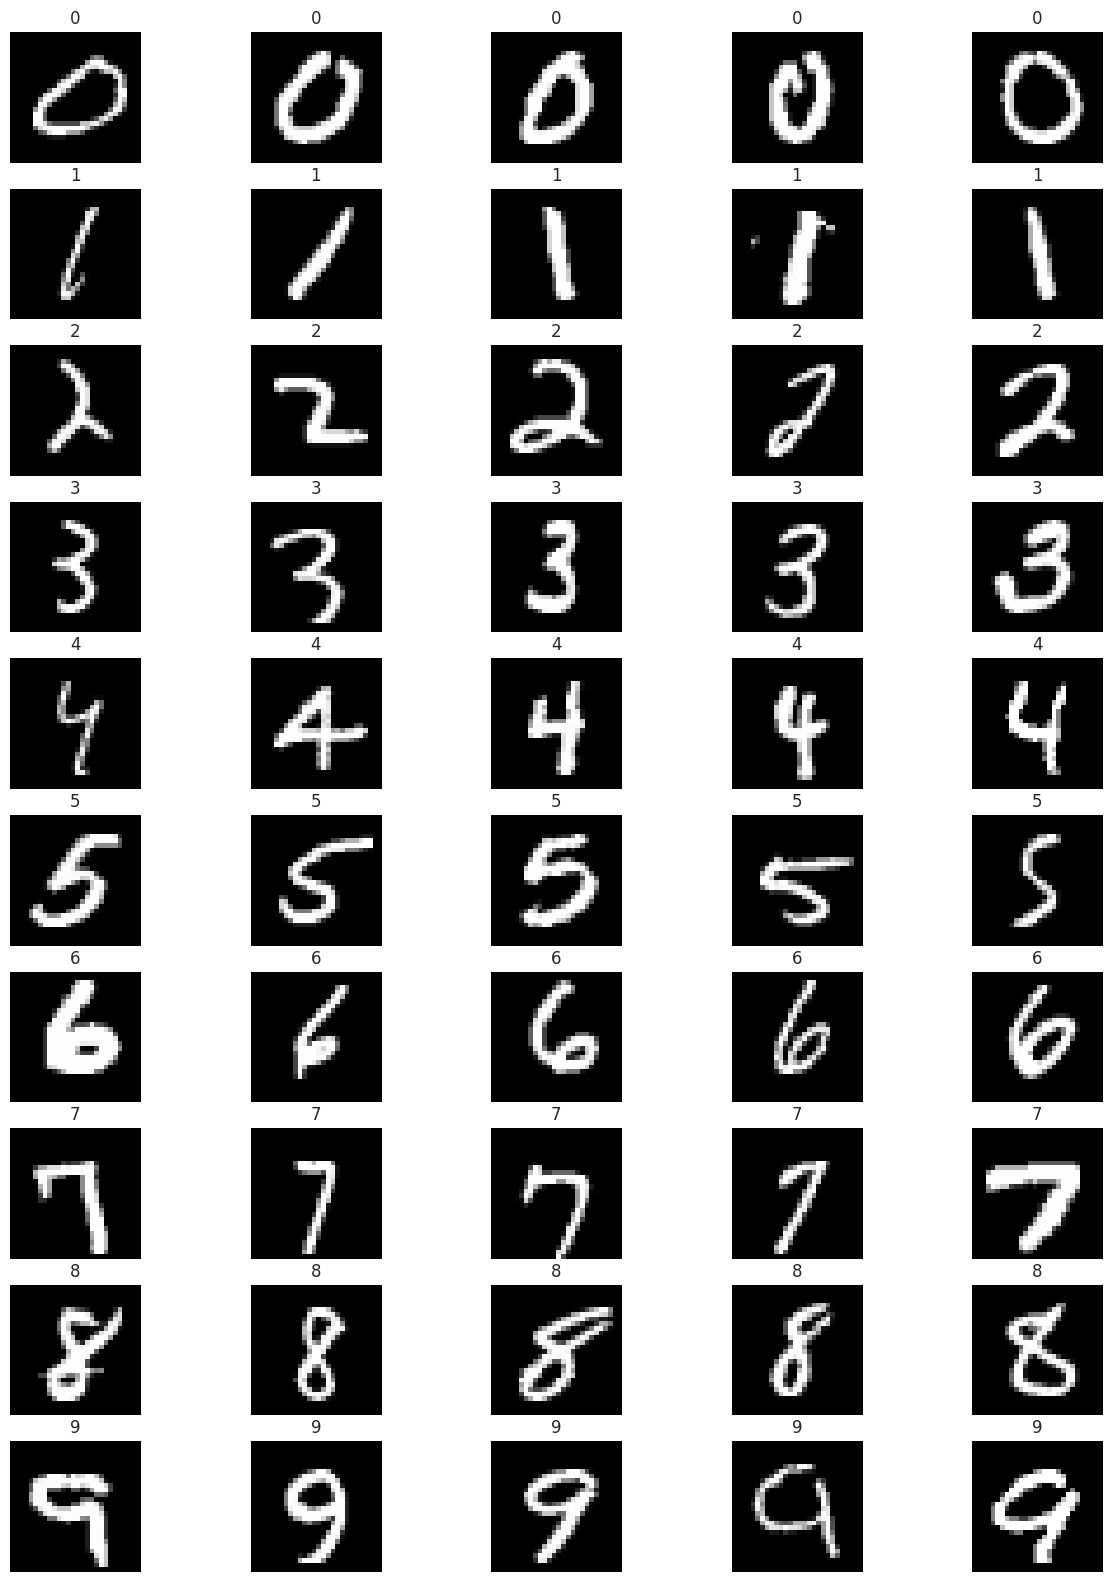

In [7]:
# 3. Displaying the first 5 images in X_train_digits for each class in
# Y_train_digits

# Mapping label_names to the appropriate number in Y_train_digits
digit_labels = [i for i in range(10)]

# Initializing the X_train_dict to map each value in Y_train_digits to the first
# five times it appears in the X_train_digits dataset
X_train_dict = {}

# Getting the first 5 images in X_train_digits for each class in Y_train_digits
for i in range(len(digit_labels)):
  X_train_dict[i] = list(np.where(Y_train_digits == i)[0][:5])

# Displaying the first 5 imgs in X_train_digits for each class in Y_train_digits
fig, axs = plt.subplots(10, 5, figsize=(15, 20))

# Going through each class (row)
for i in range(len(X_train_dict)):

  # Going through the first 5 indices that corresponds to the class
  for j in range(len(X_train_dict[i])):
    axs[i, j].imshow(X_train_digits[X_train_dict[i][j]], cmap='gray')
    axs[i, j].set_title(i)
    axs[i, j].axis('off')


### Step 4: Modeling

### <span style="color:chocolate">Exercise 2:</span> Define model (20 points)

1. Fill in the <span style="color:chocolate">build_model()</span> function below, including all the arguments listed in the function definition. Note: the activation function parameter is only for the the hidden layers; use the appropriate final classification function for the final layer.

In [65]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE

    # Setting up Sequential model
    model = tf.keras.Sequential()

    # Adding in input layer
    model.add(tf.keras.Input(shape=(28, 28), name='Input'))

    # Flattening the input layer
    model.add(tf.keras.layers.Flatten(name='Flatten'))

    # Adding in hidden layers
    for idx, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(
          units=hidden_layer_size,
          activation=activation,
          name='Hidden'+str(idx)
      ))

    # Adding output layer
    model.add(tf.keras.layers.Dense(
        units=n_classes,
        activation='softmax',
        name='Output'
    ))

    # Setting specific learning rate
    optimizer_class = getattr(tf.keras.optimizers, optimizer)
    optimizer_true = optimizer_class(learning_rate=learning_rate)

    # Using K (backend) is deprecated
    # K.set_value(model.optimizer.learning_rate, learning_rate)

    # Compiling the model
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer_true,
        metrics=[metric]
    )

    return model

---
### Step 5: Experiments

You can now run a suite of experiments to see how the hyperparameters and layer sizes effect model performance.

The <span style="color:chocolate">train_and_evaluate()</span> function below can be used to run experiments and retrieve results.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the digits model...


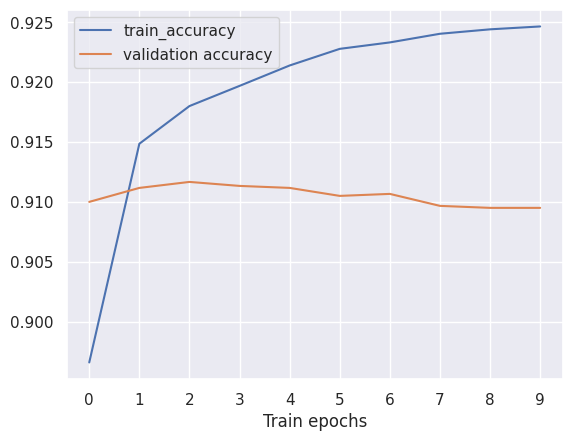

Training accuracy: 0.9246
Validation accuracy: 0.9095


In [59]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10):

  # Build the model.
    model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)
    print(model.summary())

  # Select the dataset.
    if data == 'digits':
        X_train = X_train_digits
        X_test = X_test_digits
        Y_train = Y_train_digits
        Y_test = Y_test_digits

    elif data == 'fashion':
        X_train = X_train_fashion
        X_test = X_test_fashion
        Y_train = Y_train_fashion
        Y_test = Y_test_fashion
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print('Training the', data, 'model...')
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()

    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])

    return model


# run the function
model = train_and_evaluate()

### <span style="color:chocolate">Exercise 3:</span> Ablation study (50 points)

1. Conduct experiments and record the training and validation set accuracy results in the table below. You may extend the table for additional experiments as needed.
2. Report the hyperparameter values for your preferred architecture configuration.
3. Run the model once more using your preferred hyperparameter configuration.

In [145]:
# Kept the original table here; filled out table is towards the bottom

Data | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
 digits | [] | tanh | SGD |0.01| 7850 | |
 digits | [] | relu | SGD |0.01| 7850 | |
 digits | [] | relu | Adam |0.01| 7850 | |
 digits | [128] | relu | Adam |0.01| 101770 | |
 digits | [256, 128] | relu | Adam |0.01| 235146 | |
-|-|-|-|-|-|-|-
 fashion | [] | tanh | SGD |0.01| 7850 | |
 fashion | [] | relu | SGD |0.01| 7850 | |
 fashion | [] | relu | Adam |0.01| 7850 | |
 fashion | [128] | relu | Adam |0.01| 101770 | |
 fashion | [256, 128] | relu | Adam |0.01| 235146 | |

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the digits model...


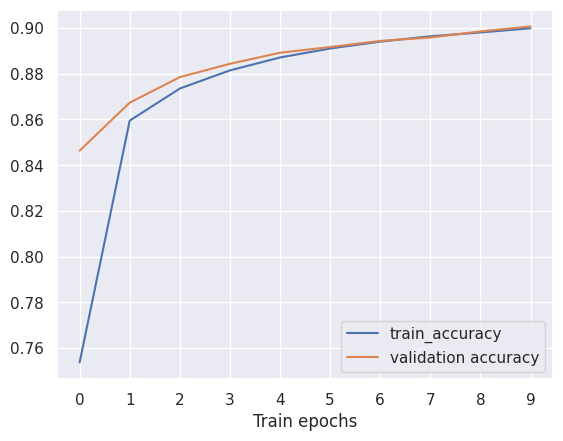

Training accuracy: 0.8999
Validation accuracy: 0.9007


In [95]:
# YOUR CODE HERE

# Digits: Hidden sizes ([]), Activation (tanh), Optimizer (SGD)
model_d_1 = train_and_evaluate(data='digits', hidden_layer_sizes=[],
  activation='tanh', optimizer='SGD')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the digits model...


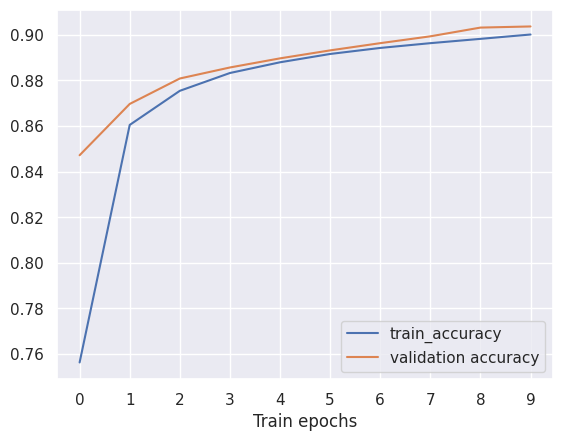

Training accuracy: 0.9001
Validation accuracy: 0.9037


In [96]:
# Digits: Hidden sizes ([]), Activation (relu), Optimizer (SGD)
model_d_2 = train_and_evaluate(data='digits', hidden_layer_sizes=[],
  activation='relu', optimizer='SGD')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the digits model...


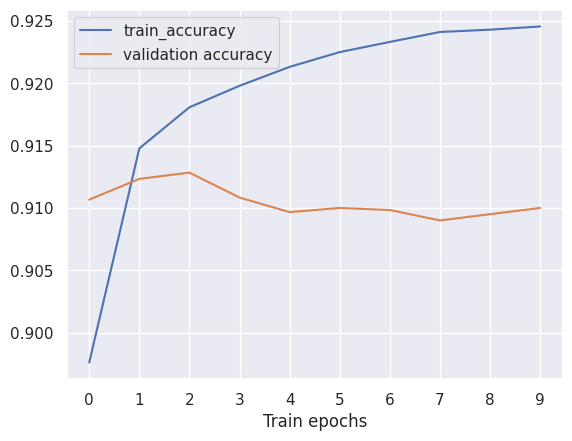

Training accuracy: 0.9246
Validation accuracy: 0.9100


In [97]:
# Digits: Hidden sizes ([]), Activation (relu), Optimizer (Adam)
model_d_3 = train_and_evaluate(data='digits', hidden_layer_sizes=[],
  activation='relu', optimizer='Adam')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden0 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the digits model...


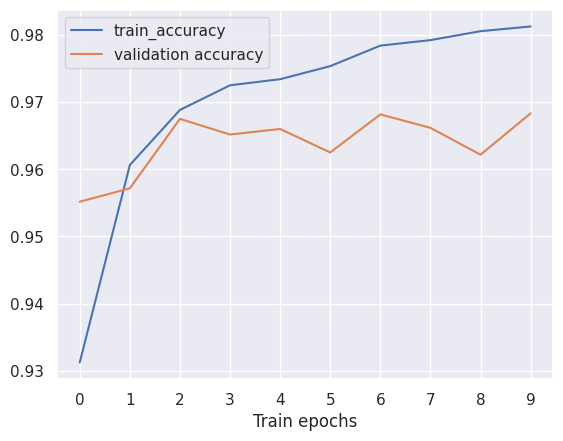

Training accuracy: 0.9813
Validation accuracy: 0.9683


In [98]:
# Digits: Hidden sizes ([128]), Activation (relu), Optimizer (Adam)
model_d_4 = train_and_evaluate(data='digits', hidden_layer_sizes=[128],
  activation='relu', optimizer='Adam')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden0 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the digits model...


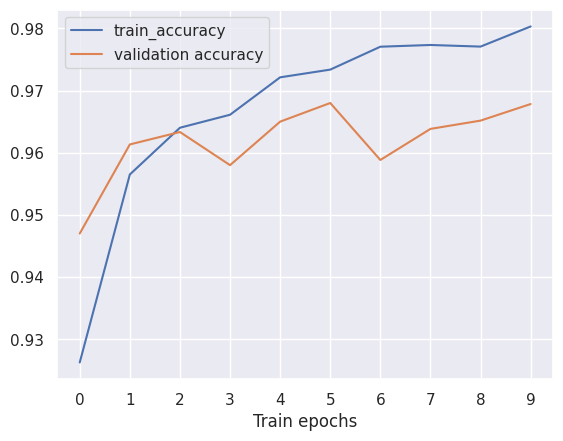

Training accuracy: 0.9803
Validation accuracy: 0.9678


In [110]:
# Digits: Hidden sizes ([256, 128]), Activation (relu), Optimizer (Adam)
model_d_5 = train_and_evaluate(data='digits', hidden_layer_sizes=[256, 128],
  activation='relu', optimizer='Adam')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the fashion model...


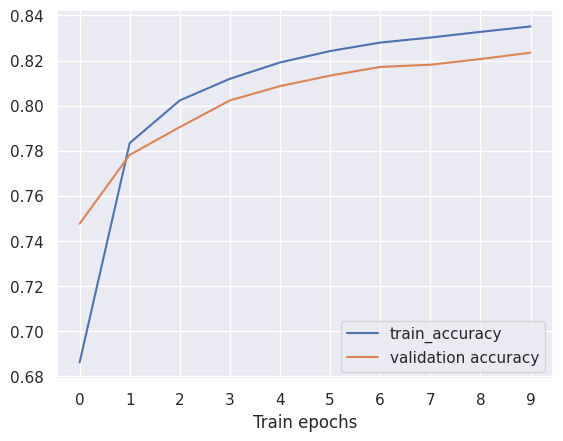

Training accuracy: 0.8351
Validation accuracy: 0.8235


In [100]:
# Fashion: Hidden sizes ([]), Activation (tanh), Optimizer (SGD)
model_f_1 = train_and_evaluate(data='fashion', hidden_layer_sizes=[],
  activation='tanh', optimizer='SGD')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the fashion model...


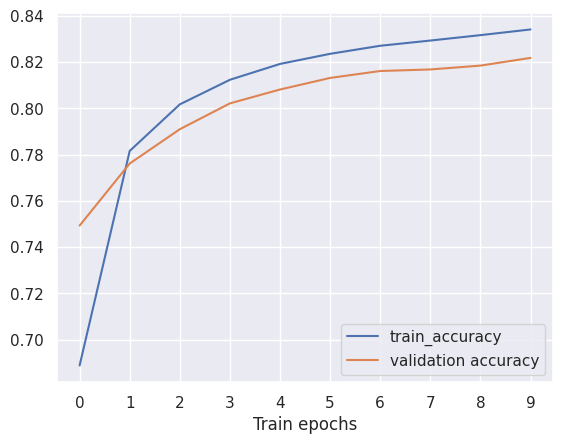

Training accuracy: 0.8341
Validation accuracy: 0.8218


In [101]:
# Fashion: Hidden sizes ([]), Activation (relu), Optimizer (SGD)
model_f_2 = train_and_evaluate(data='fashion', hidden_layer_sizes=[],
  activation='relu', optimizer='SGD')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the fashion model...


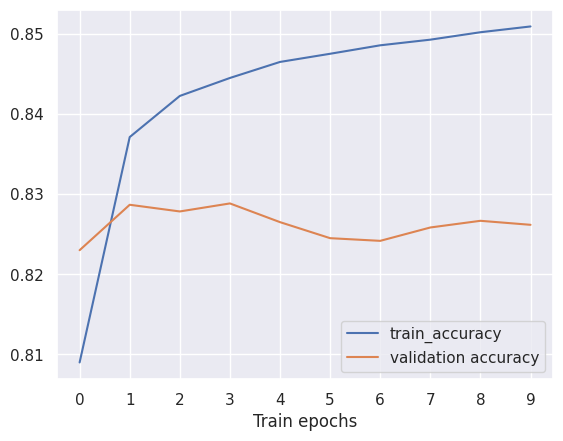

Training accuracy: 0.8509
Validation accuracy: 0.8262


In [102]:
# Fashion: Hidden sizes ([]), Activation (relu), Optimizer (Adam)
model_f_3 = train_and_evaluate(data='fashion', hidden_layer_sizes=[],
  activation='relu', optimizer='Adam')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden0 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the fashion model...


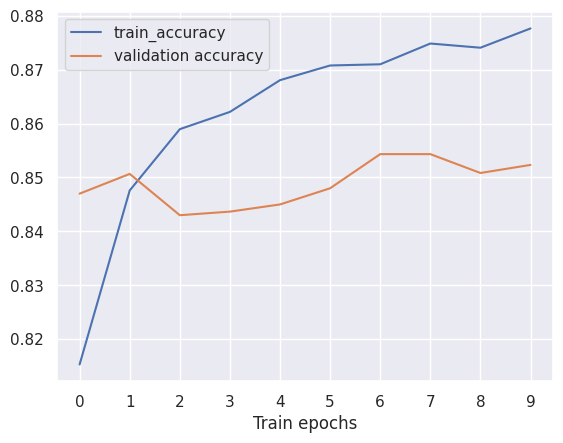

Training accuracy: 0.8776
Validation accuracy: 0.8523


In [108]:
# Fashion: Hidden sizes ([128]), Activation (relu), Optimizer (Adam)
model_f_4 = train_and_evaluate(data='fashion', hidden_layer_sizes=[128],
  activation='relu', optimizer='Adam')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden0 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the fashion model...


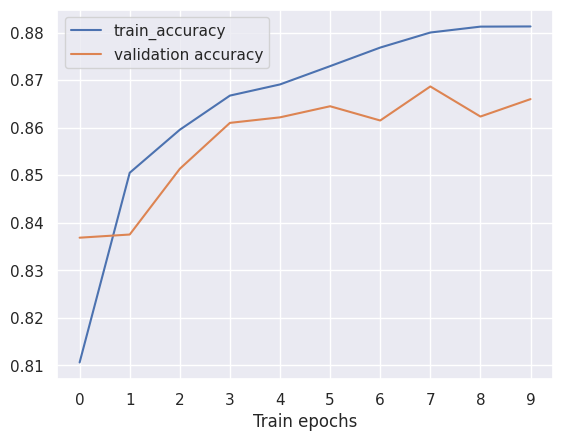

Training accuracy: 0.8813
Validation accuracy: 0.8660


In [114]:
# Fashion: Hidden sizes ([256, 128]), Activation (relu), Optimizer (Adam)
model_f_5 = train_and_evaluate(data='fashion', hidden_layer_sizes=[256, 128],
  activation='relu', optimizer='Adam')

In [115]:
# 1. Getting the train accuracy and validation accuracy of all models ran above

# Getting accuracies for digits dataset
model_d_1_acc = model_d_1.history.history['accuracy'][-1]
model_d_1_val_acc = model_d_1.history.history['val_accuracy'][-1]
model_d_2_acc = model_d_2.history.history['accuracy'][-1]
model_d_2_val_acc = model_d_2.history.history['val_accuracy'][-1]
model_d_3_acc = model_d_3.history.history['accuracy'][-1]
model_d_3_val_acc = model_d_3.history.history['val_accuracy'][-1]
model_d_4_acc = model_d_4.history.history['accuracy'][-1]
model_d_4_val_acc = model_d_4.history.history['val_accuracy'][-1]
model_d_5_acc = model_d_5.history.history['accuracy'][-1]
model_d_5_val_acc = model_d_5.history.history['val_accuracy'][-1]

# Getting accuracies for fashion dataset
model_f_1_acc = model_f_1.history.history['accuracy'][-1]
model_f_1_val_acc = model_f_1.history.history['val_accuracy'][-1]
model_f_2_acc = model_f_2.history.history['accuracy'][-1]
model_f_2_val_acc = model_f_2.history.history['val_accuracy'][-1]
model_f_3_acc = model_f_3.history.history['accuracy'][-1]
model_f_3_val_acc = model_f_3.history.history['val_accuracy'][-1]
model_f_4_acc = model_f_4.history.history['accuracy'][-1]
model_f_4_val_acc = model_f_4.history.history['val_accuracy'][-1]
model_f_5_acc = model_f_5.history.history['accuracy'][-1]
model_f_5_val_acc = model_f_5.history.history['val_accuracy'][-1]

print("1. Digits dataset training and validation accuracies:")
for i in range(5):
  acc_str = "model_d_" + str(i+1) + "_acc"
  acc_value = round(globals().get(acc_str), 4)
  val_acc_str = "model_d_" + str(i+1) + "_val_acc"
  val_acc_value = round(globals().get(val_acc_str), 4)
  print(" - Training accuracy for " + acc_str + ": " + str(acc_value))
  print(" - Validation accuracy for " + val_acc_str + ": " + str(val_acc_value))

print("\nFashion dataset training and validation accuracies:")
for i in range(5):
  acc_str = "model_f_" + str(i+1) + "_acc"
  acc_value = round(globals().get(acc_str), 4)
  val_acc_str = "model_f_" + str(i+1) + "_val_acc"
  val_acc_value = round(globals().get(val_acc_str), 4)
  print(" - Training accuracy for " + acc_str + ": " + str(acc_value))
  print(" - Validation accuracy for " + val_acc_str + ": " + str(val_acc_value))


1. Digits dataset training and validation accuracies:
 - Training accuracy for model_d_1_acc: 0.8999
 - Validation accuracy for model_d_1_val_acc: 0.9007
 - Training accuracy for model_d_2_acc: 0.9001
 - Validation accuracy for model_d_2_val_acc: 0.9037
 - Training accuracy for model_d_3_acc: 0.9246
 - Validation accuracy for model_d_3_val_acc: 0.91
 - Training accuracy for model_d_4_acc: 0.9813
 - Validation accuracy for model_d_4_val_acc: 0.9683
 - Training accuracy for model_d_5_acc: 0.9803
 - Validation accuracy for model_d_5_val_acc: 0.9678

Fashion dataset training and validation accuracies:
 - Training accuracy for model_f_1_acc: 0.8351
 - Validation accuracy for model_f_1_val_acc: 0.8235
 - Training accuracy for model_f_2_acc: 0.8341
 - Validation accuracy for model_f_2_val_acc: 0.8218
 - Training accuracy for model_f_3_acc: 0.8509
 - Validation accuracy for model_f_3_val_acc: 0.8262
 - Training accuracy for model_f_4_acc: 0.8776
 - Validation accuracy for model_f_4_val_acc: 0.

Data | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
 digits | [] | tanh | SGD |0.01| 7850 | 0.8999 | 0.9007
 digits | [] | relu | SGD |0.01| 7850 | 0.9001 | 0.9037
 digits | [] | relu | Adam |0.01| 7850 | 0.9246 | 0.9100
 digits | [128] | relu | Adam |0.01| 101770 | 0.9813 | 0.9683
 digits | [256, 128] | relu | Adam |0.01| 235146 | 0.9803 | 0.9678
-|-|-|-|-|-|-|-
 fashion | [] | tanh | SGD |0.01| 7850 | 0.8351 | 0.8235
 fashion | [] | relu | SGD |0.01| 7850 | 0.8341 | 0.8218
 fashion | [] | relu | Adam |0.01| 7850 | 0.8509 | 0.8262
 fashion | [128] | relu | Adam |0.01| 101770 | 0.8776 | 0.8523
 fashion | [256, 128] | relu | Adam |0.01| 235146 | 0.8813 | 0.8660

In [117]:
# 2. Reporting hyperparameter values for preferred architecture configuration

print("2. Reporting the hyperparameter values for preferred architecture"
  "configuration:\n")

print("For the digits dataset, the penultimate architecture configuration had")
print("both the highest training and validation accuracy, albeit they were")
print("only slightly higher than the last architecture.")
print(" - Hyperparameter values for optimal architecture configuration:")
print(" - Hidden layer sizes: [128]")
print(" - Activation: relu")
print(" - Optimizer: Adam")
print(" - Learning rate: 0.01")
print(" - Epochs: 10")
print(" - Batch size: 64\n")

print("For the fashion dataset, the last architecture configuration had the")
print("highest training and validation accuracy, but they were similarly only")
print("slightly better than the penultimate architecture.")
print(" - Hyperparameter values for optimal architecture configuration:")
print(" - Hidden layer sizes: [256, 128]")
print(" - Activation: relu")
print(" - Optimizer: Adam")
print(" - Learning rate: 0.01")
print(" - Epochs: 10")
print(" - Batch size: 64")


2. Reporting the hyperparameter values for preferred architectureconfiguration:

For the digits dataset, the penultimate architecture configuration had
both the highest training and validation accuracy, albeit they were
only slightly higher than the last architecture.
 - Hyperparameter values for optimal architecture configuration:
 - Hidden layer sizes: [128]
 - Activation: relu
 - Optimizer: Adam
 - Learning rate: 0.01
 - Epochs: 10
 - Batch size: 64

For the fashion dataset, the last architecture configuration had the
highest training and validation accuracy, but they were similarly only
slightly better than the penultimate architecture.
 - Hyperparameter values for optimal architecture configuration:
 - Hidden layer sizes: [256, 128]
 - Activation: relu
 - Optimizer: Adam
 - Learning rate: 0.01
 - Epochs: 10
 - Batch size: 64


In [121]:
# 3. Running the model once more using preferred hyperparameter configuration

print("3. Running the preferred models once more and getting their final model")
print("training and validation accuracies:")

3. Running the preferred models once more and getting their final model
training and validation accuracies:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden0 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the digits model...


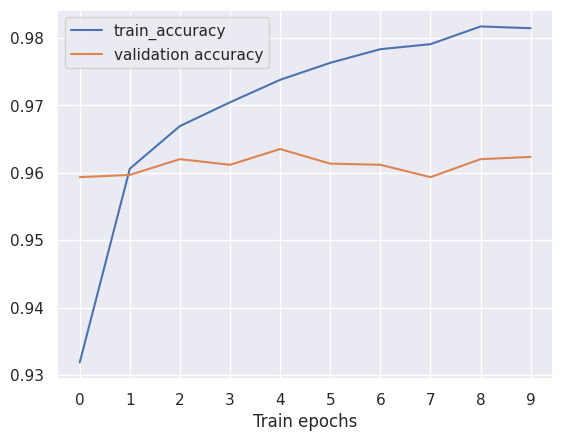

Training accuracy: 0.9814
Validation accuracy: 0.9623
For the digits dataset, the final training and validation accuracies
for the optimal hyperparameter configuration were as follow:
 - Training accuracy: 0.9814074039459229
 - Validation accuracy: 0.9623333215713501


In [122]:
# Digits: Hidden sizes ([128]), Activation (relu), Optimizer (Adam)
model_d_optimal = train_and_evaluate(data='digits', hidden_layer_sizes=[128],
  activation='relu', optimizer='Adam')

print("For the digits dataset, the final training and validation accuracies")
print("for the optimal hyperparameter configuration were as follow:")
print(" - Training accuracy:", model_d_optimal.history.history['accuracy'][-1])
print(" - Validation accuracy:",
  model_d_optimal.history.history['val_accuracy'][-1])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden0 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the fashion model...


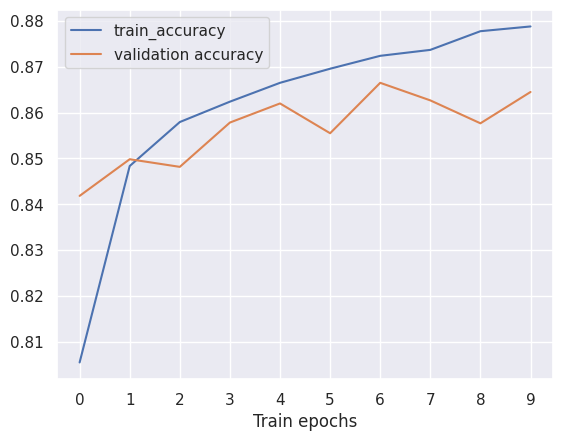

Training accuracy: 0.8788
Validation accuracy: 0.8645

For the fashion dataset, the final training and validation accuracies
for the optimal hyperparameter configuration were as follow:
 - Training accuracy: 0.8787962794303894
 - Validation accuracy: 0.8644999861717224


In [126]:
# Fashion: Hidden sizes ([256, 128]), Activation (relu), Optimizer (Adam)
model_f_optimal = train_and_evaluate(data='fashion',
  hidden_layer_sizes=[256, 128], activation='relu', optimizer='Adam')

print("\nFor the fashion dataset, the final training and validation accuracies")
print("for the optimal hyperparameter configuration were as follow:")
print(" - Training accuracy:", model_f_optimal.history.history['accuracy'][-1])
print(" - Validation accuracy:",
  model_f_optimal.history.history['val_accuracy'][-1])

---
### Step 6: Evaluation and Generalization

### <span style="color:chocolate">Exercise 4:</span> Compute metrics (25 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras and the <span style="color:chocolate">np.max()</span> method available in NumPy; or you can use the <span style="color:chocolate">model.evaluare()</span> method provided by tf.keras directly.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your accuracy observations.

In [139]:
# YOUR CODE HERE

# 1. Calculating accuracy on both train and test datasets

# Caculating predictions for the digits dataset
Y_train_digits_pred = model_d_optimal.predict(x=X_train_digits)
Y_test_digits_pred = model_d_optimal.predict(x=X_test_digits)

Y_train_digits_pred = Y_train_digits_pred.argmax(axis = 1)
Y_test_digits_pred = Y_test_digits_pred.argmax(axis = 1)

# Caculating predictions for the fashion dataset
Y_train_fashion_pred = model_f_optimal.predict(x=X_train_fashion)
Y_test_fashion_pred = model_f_optimal.predict(x=X_test_fashion)

Y_train_fashion_pred = Y_train_fashion_pred.argmax(axis = 1)
Y_test_fashion_pred = Y_test_fashion_pred.argmax(axis = 1)

print("\n1. For the digits dataset:")
print("Aggregate training accuracy using tf.keras.metrics.Accuracy():",
  tf.keras.metrics.Accuracy()(Y_train_digits, Y_train_digits_pred).numpy())
print("Aggregate training accuracy using model.evaluate():",
  model_d_optimal.evaluate(X_train_digits, Y_train_digits, verbose = 0)[1])
print("\nAggregate test accuracy using tf.keras.metrics.Accuracy():",
  tf.keras.metrics.Accuracy()(Y_test_digits, Y_test_digits_pred).numpy())
print("Aggregate test accuracy using model.evaluate():",
  model_d_optimal.evaluate(X_test_digits, Y_test_digits, verbose = 0)[1], '\n')

print("############\n")

print("For the fashion dataset:")
print("Aggregate training accuracy using tf.keras.metrics.Accuracy():",
  tf.keras.metrics.Accuracy()(Y_train_fashion, Y_train_fashion_pred).numpy())
print("Aggregate training accuracy using model.evaluate():",
  model_f_optimal.evaluate(X_train_fashion, Y_train_fashion, verbose = 0)[1])
print("\nAggregate test accuracy using tf.keras.metrics.Accuracy():",
  tf.keras.metrics.Accuracy()(Y_test_fashion, Y_test_fashion_pred).numpy())
print("Aggregate test accuracy using model.evaluate():",
  model_f_optimal.evaluate(X_test_fashion, Y_test_fashion, verbose = 0)[1])


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1. For the digits dataset:
Aggregate training accuracy using tf.keras.metrics.Accuracy(): 0.9751
Aggregate training accuracy using model.evaluate(): 0.9750999808311462

Aggregate test accuracy using tf.keras.metrics.Accuracy(): 0.9642
Aggregate test accuracy using model.evaluate(): 0.9642000198364258 

############

For the fashion dataset:
Aggregate training accuracy using tf.keras.metrics.Accuracy(): 0.8885667
Aggregate training accuracy using model.evaluate(): 0.8885666728019714

Aggregate test accuracy using tf.keras.metrics.Accuracy(): 0.8615
Aggregate test accuracy using model.evaluate(): 0.8615000247955322


In [144]:
# 2. Analyzing how well the model generalizes

print("2. Overall, the models seem to generalize pretty well for both the")
print("digits dataset and the fashion dataset. The test accuracies were")
print("obviously a bit lower for both, but they're comparable to the")
print("validation accuracies for their respective models. But even just")
print("looking at the test accuracies themselves, ~96% for the digits dataset")
print("and ~86% for the fashion dataset is remarkable, especially compared to")
print("what we've seen in previous assignments. One potential test to conduct")
print("in the future would be to analyze each specific class and see how well")
print("the model performs against each one. That way, we might be able to get")
print("a better sense of what the model has trouble analyzing for each.\n")

print("In terms of comparing the datasets, the trained models had an easier")
print("time with the digits dataset pretty much across the board. However,")
print("this makes quite a bit of sense, as a quick glance at the images in")
print("each dataset quickly reveals the difference in complexity between")
print("digits and clothing/fashion items.\n")

print("One last thing to note is that for both datasets, the model with 1")
print("hidden layer (128 units) performed nearly as well - if not better than")
print("- the model with 2 hidden layers (256 units, 128 units). This is quite")
print("interesting, as we might expect a model with more hidden layers to")
print("capture more features, thereby making the predictions more accurate.")
print("One potential explanation would be overfitting, as perhaps the increase")
print("in hidden layers actually causes the model to overfit too heavily")
print("(which we can somewhat see when comparing the validation and training")
print("accuracies).")

2. Overall, the models seem to generalize pretty well for both the
digits dataset and the fashion dataset. The test accuracies were
obviously a bit lower for both, but they're comparable to the
validation accuracies for their respective models. But even just
looking at the test accuracies themselves, ~96% for the digits dataset
and ~86% for the fashion dataset is remarkable, especially compared to
what we've seen in previous assignments. One potential test to conduct
in the future would be to analyze each specific class and see how well
the model performs against each one. That way, we might be able to get
a better sense of what the model has trouble analyzing for each.

In terms of comparing the datasets, the trained models had an easier
time with the digits dataset pretty much across the board. However,
this makes quite a bit of sense, as a quick glance at the images in
each dataset quickly reveals the difference in complexity between
digits and clothing/fashion items.

One last thin